In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
from gwpy.timeseries import TimeSeries
from pycbc.waveform import get_td_waveform
import pycbc.waveform as pw

# For making things interactive
import ipywidgets as widgets
from IPython.display import display

/opt/anaconda3/envs/proj_codeastro/lib/python3.10/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"], # Use CMR or fall back to Times
    # "font.serif": ["Computer Modern Roman", "Times New Roman"], # Use CMR or fall back to Times
    "font.size": 14,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "axes.titlesize": 18,
    "figure.dpi": 300, # High resolution for crisp output
})

In [3]:
# url = "https://gwosc.org/api/v2/event-versions?include-default-parameters=true&format=csv"
# read url from the url txt file
# url_file = 'https://github.com/DeveshGiri/play-with-gwtc-events/blob/notebooks/data/url.txt'
url_file = "url.txt"
with open(url_file, 'r') as file:
    url = file.read().strip()

In [4]:
# Use pandas to read the csv into a DataFrame
try:
    gw_events_df = pd.read_csv(url)
    print("Data downloaded and loaded into DataFrame successfully.")

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please check the URL or your internet connection.")

Data downloaded and loaded into DataFrame successfully.


In [5]:
# You can check the first five rows of the DataFrame to understand its structure using
# gw_events_df.head()

In [6]:
print("\nAvailable columns:")
print(list(gw_events_df.columns))


Available columns:
['name', 'shortName', 'gps', 'version', 'catalog', 'doi', 'detail_url', 'mass_1_source', 'mass_1_source_lower', 'mass_1_source_upper', 'mass_2_source', 'mass_2_source_lower', 'mass_2_source_upper', 'network_matched_filter_snr', 'network_matched_filter_snr_lower', 'network_matched_filter_snr_upper', 'luminosity_distance', 'luminosity_distance_lower', 'luminosity_distance_upper', 'chi_eff', 'chi_eff_lower', 'chi_eff_upper', 'total_mass_source', 'total_mass_source_lower', 'total_mass_source_upper', 'chirp_mass_source', 'chirp_mass_source_lower', 'chirp_mass_source_upper', 'chirp_mass', 'chirp_mass_lower', 'chirp_mass_upper', 'redshift', 'redshift_lower', 'redshift_upper', 'far', 'far_lower', 'far_upper', 'p_astro', 'p_astro_lower', 'p_astro_upper', 'final_mass_source', 'final_mass_source_lower', 'final_mass_source_upper']


In [7]:
# gw_events_df

In [8]:
gw_event_dict = {}

for index, row in gw_events_df.iterrows():
    event_name = row['name']
    # print(index)
    # Check for missing essential data before adding to dictionary
    required_cols = ['gps', 'mass_1_source', 'mass_2_source', 'network_matched_filter_snr', 
                     'luminosity_distance', 'chi_eff', 'total_mass_source', 'chirp_mass_source', 'redshift', 'final_mass_source']
    
    # if not row[required_cols].isnull().any():

    event_data = (
        row['gps'],
        row['mass_1_source'],
        row['mass_2_source'],
        row['network_matched_filter_snr'],
        row['luminosity_distance'],
        row['chi_eff'],
        row['total_mass_source'],
        row['chirp_mass_source'],
        row['redshift'],
        row['final_mass_source']
    )
    # print('adding', event_name, 'to the dictionary')
    gw_event_dict[event_name] = event_data

In [9]:
print("Data for GW150914:")
print(gw_event_dict.get('GW150914'))

# Print the number of events successfully parsed
print(f"\nSuccessfully created a dictionary with {len(gw_event_dict)} events.")
print(f"\nThere are {len(gw_events_df['name']) - len(gw_event_dict)} duplicate events:")
print("We have considered the versions which come last in the table.")

Data for GW150914:
(1126259462.4, 35.6, 30.6, 26.0, 440.0, -0.01, nan, 28.6, 0.09, 63.1)

Successfully created a dictionary with 133 events.

There are 92 duplicate events:
We have considered the versions which come last in the table.


Generating Q-transform for GW150914 at GPS time 1126259462.4 from H1.


/opt/anaconda3/envs/proj_codeastro/lib/python3.10/site-packages/gwpy/plot/plot.py:296: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  super().show(warn=warn)


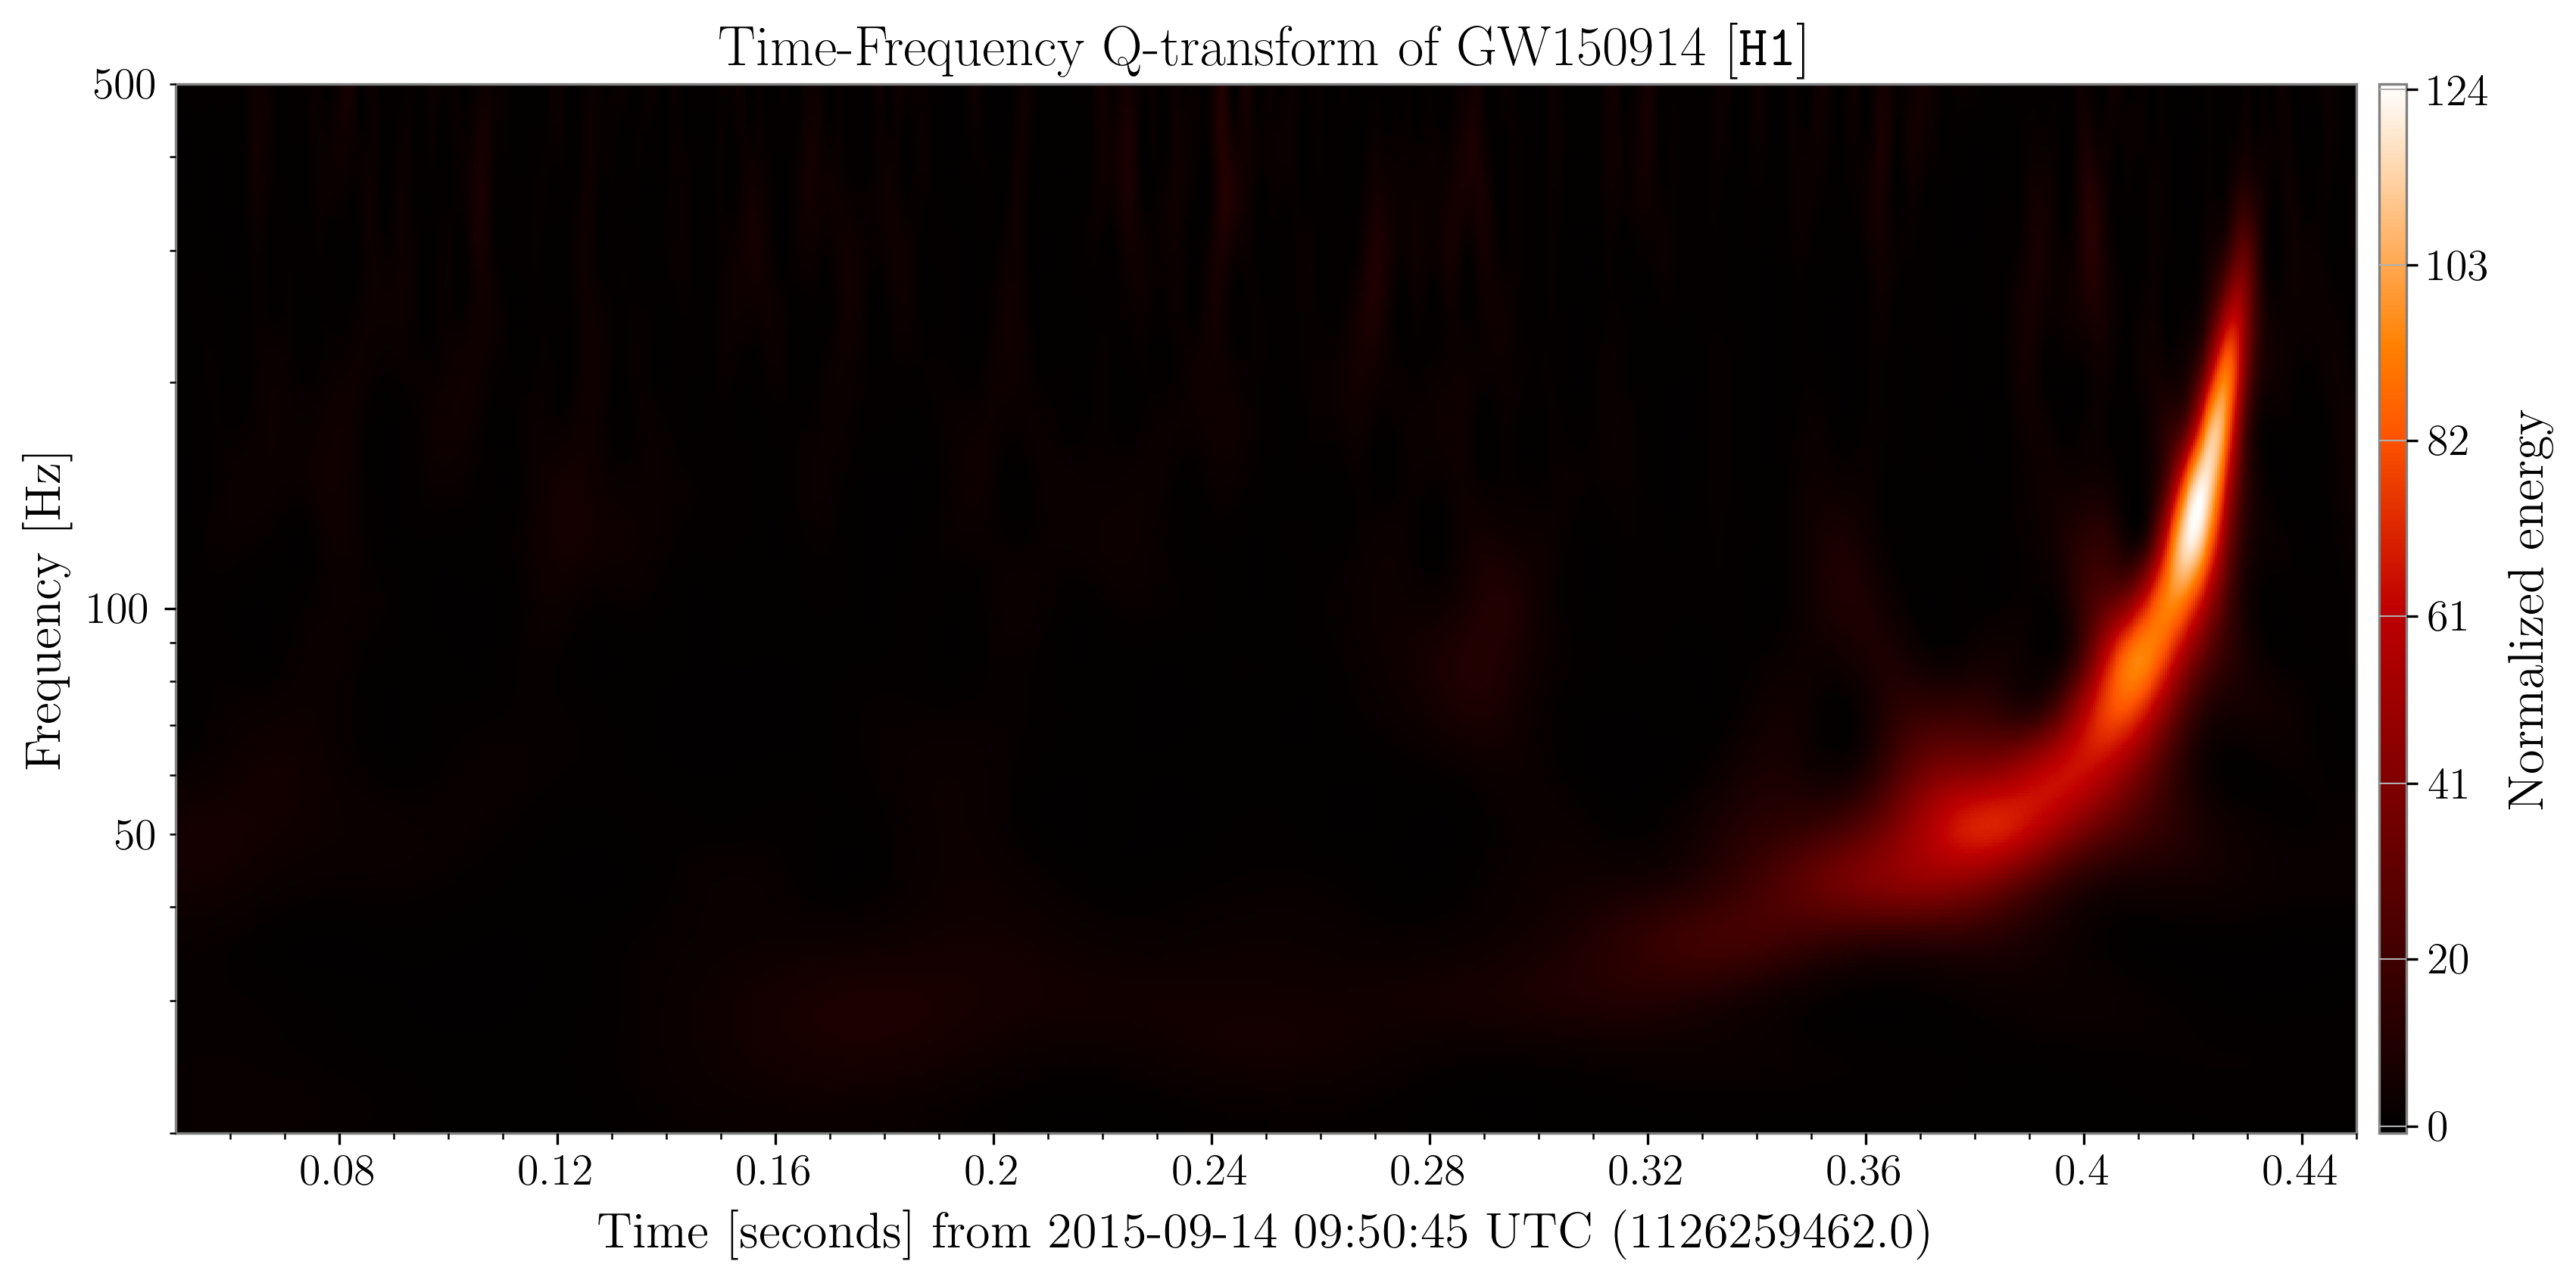

In [10]:
event_name = 'GW150914'
detector = 'H1' # Hanford detector

# Get the GPS time from our dictionary
event_gps_time = gw_event_dict[event_name][0]
print(f"Generating Q-transform for {event_name} at GPS time {event_gps_time} from {detector}.")

# Fetch the strain data using gwpy
# We will fetch 4 seconds of data centered on the event time
try:
    data = TimeSeries.fetch_open_data(detector, event_gps_time - 16, event_gps_time + 16)

    # A Q-transform requires a few parameters. We'll use standard ones.
    # It scans for signals across a range of frequencies and Q values.
    # Q is the "quality factor" of the wavelet, ~ f / delta_f
    # qscan = data.q_transform(frange=(30, 500), qrange=(5, 60))
    # Or, using the gwpy default:
    qscan = data.q_transform(outseg=(event_gps_time-0.35, event_gps_time+0.05))

    # Plot the Q-transform
    plot = qscan.plot(figsize=[12, 6])
    ax = plot.gca()
    ax.set_xscale('seconds')
    ax.set_yscale('log')
    ax.set_ylim(20, 500)
    ax.set_ylabel('Frequency [Hz]')
    cbar = ax.colorbar(cmap='gist_heat', label='Normalized energy')
    cbar.set_ticks(np.linspace(qscan.value.min(), qscan.value.max(), num=7).astype(int))
    # ax.grid(True, axis='y', which='both')
    ax.grid(False)
    ax.set_title(fr"Time-Frequency Q-transform of {event_name} $\mathtt{{[{detector}]}}$")
    plot.show()

except Exception as e:
    print(f"Could not fetch or plot data. Error: {e}")
    print("This can happen if open data is not available for this specific time or detector.")

In [11]:
required_cols

['gps',
 'mass_1_source',
 'mass_2_source',
 'network_matched_filter_snr',
 'luminosity_distance',
 'chi_eff',
 'total_mass_source',
 'chirp_mass_source',
 'redshift',
 'final_mass_source']

Generating IMRPhenomXPHM waveform for GW150914 with:
  m1: 35.6 M_sun, m2: 30.6 M_sun, distance: 440.0 Mpc, spin1z/spin2z ~ -0.01


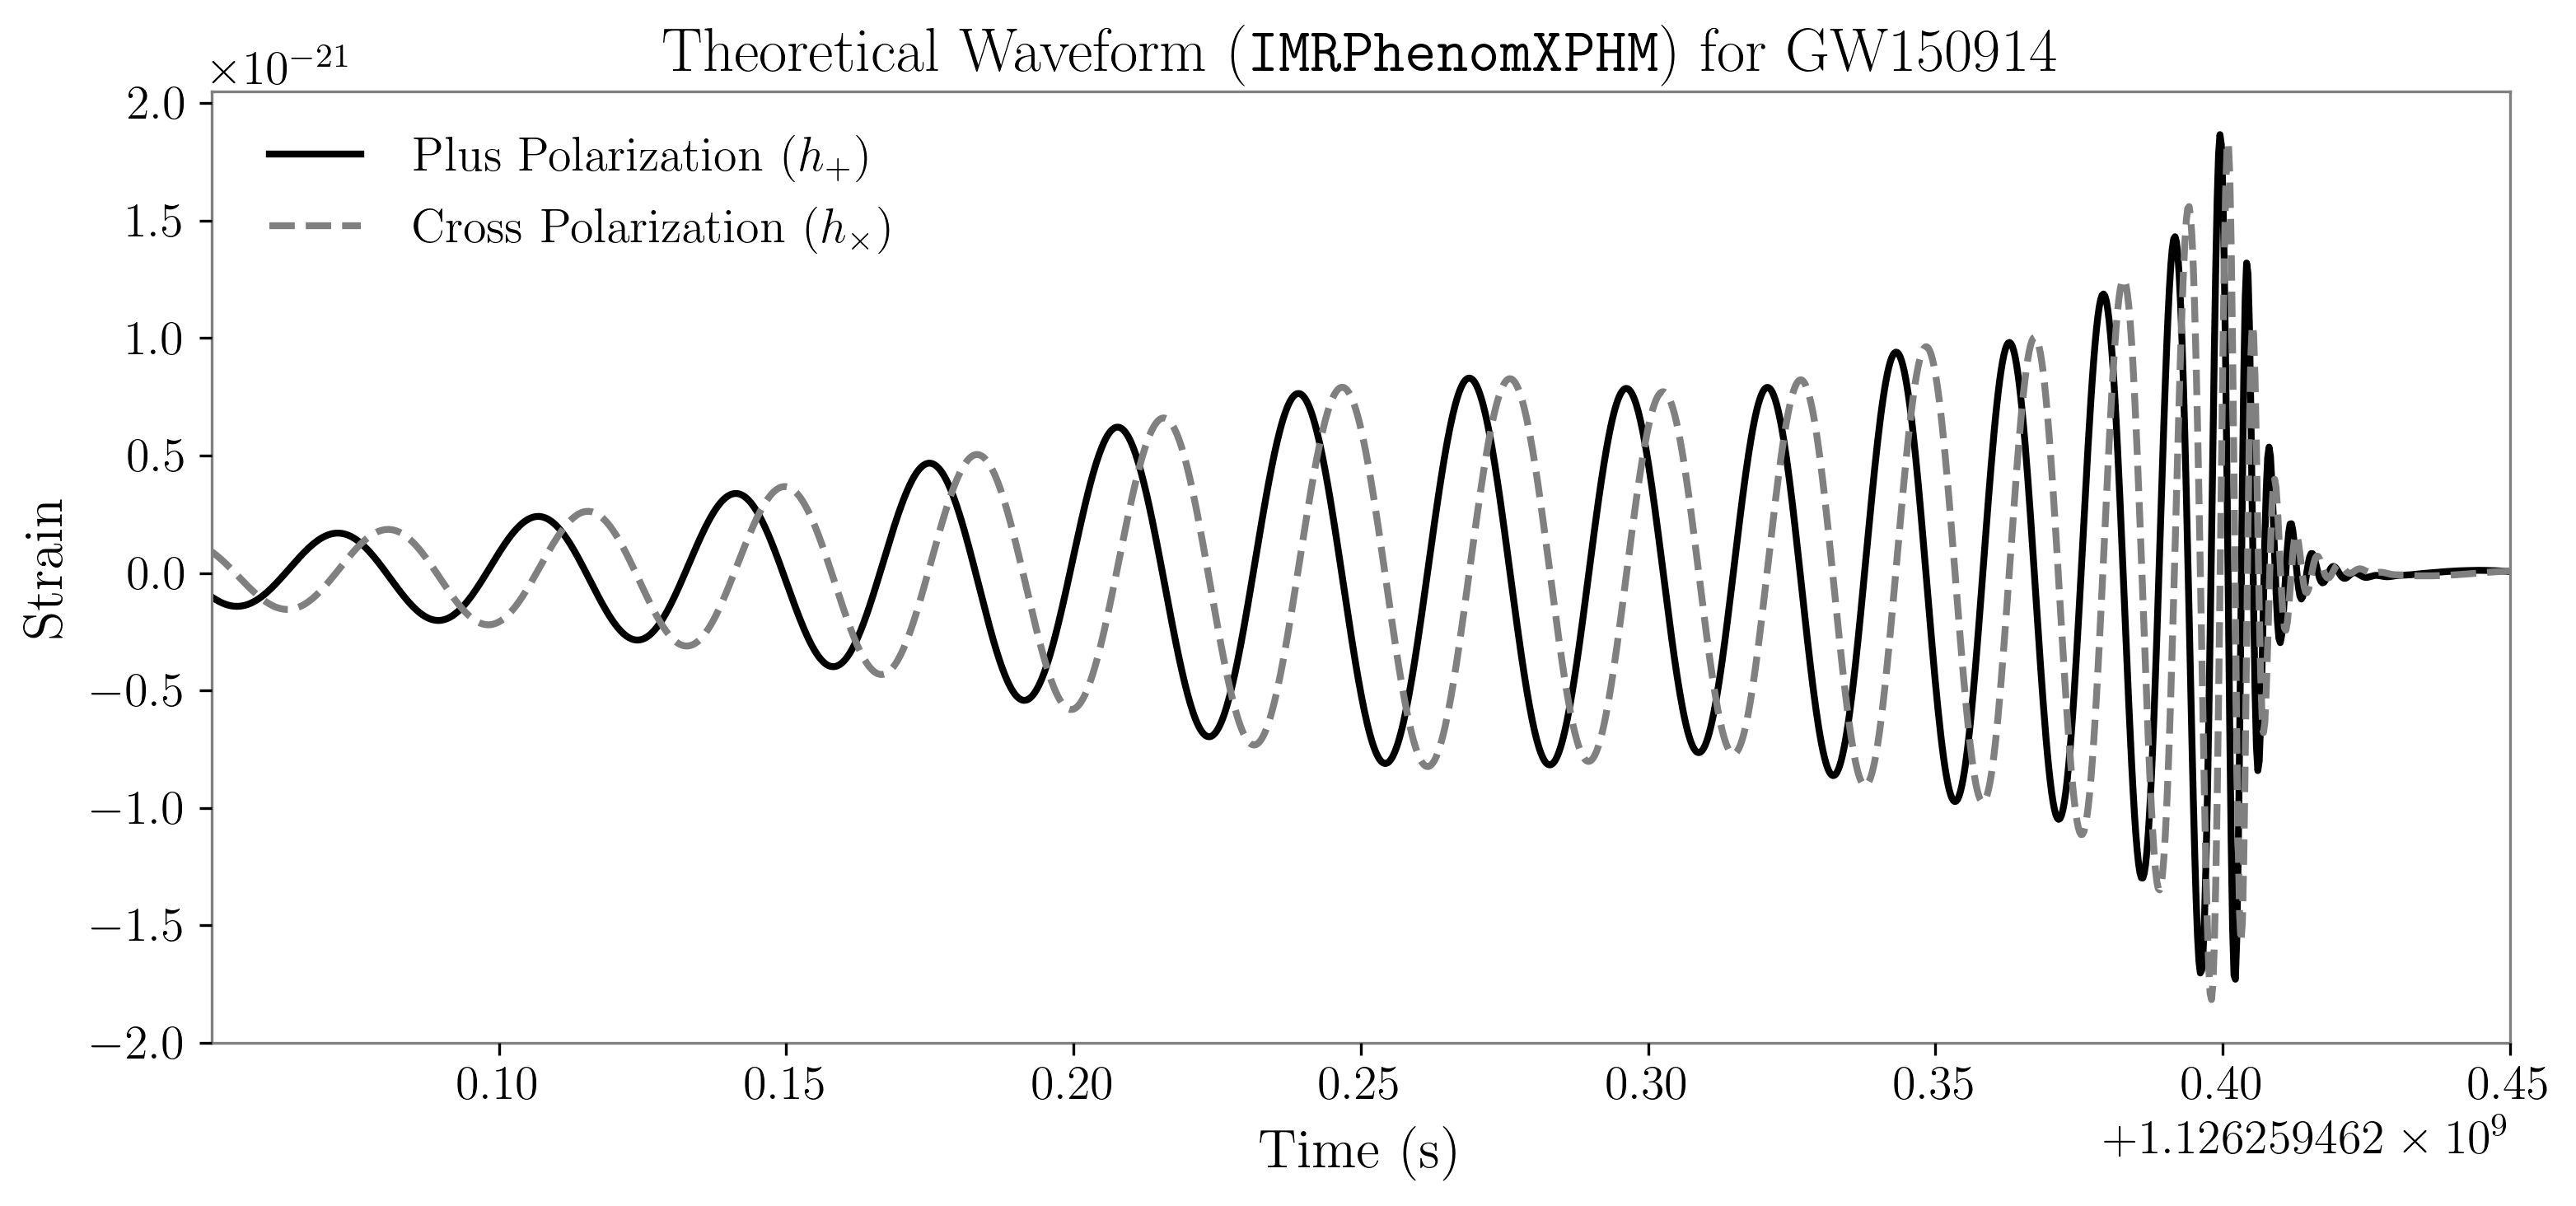

In [12]:
try:
    event_params = gw_event_dict[event_name]
    event_gps_time = event_params[0]
    m1 = event_params[1]  # Mass 1
    m2 = event_params[2]  # Mass 2
    distance = event_params[4] # Luminosity distance
    spin1z = event_params[5] # We use chi_eff as a proxy for z-spins for this simple model
    
    print(f"Generating IMRPhenomXPHM waveform for {event_name} with:")
    print(f"  m1: {m1} M_sun, m2: {m2} M_sun, distance: {distance} Mpc, spin1z/spin2z ~ {spin1z}")

    hp, hc = get_td_waveform(approximant='IMRPhenomXPHM',
                             mass1=m1,
                             mass2=m2,
                             spin1z=spin1z, # Assuming spins are aligned and chi_eff is a good proxy
                             spin2z=spin1z, # Simplification / assumption (in principle, could be different)
                             distance=distance,
                             delta_t=1.0/4096,
                             f_lower=30)
    
    plt.figure(figsize=(12, 5))
    plt.plot(hp.sample_times + event_gps_time, hp, color='black', linestyle='-', lw=2, label='Plus Polarization ($h_+$)')
    plt.plot(hc.sample_times + event_gps_time, hc, color='gray', linestyle='--', lw=2, label='Cross Polarization ($h_\\times$)')
    plt.xlabel('Time (s)')
    plt.ylabel('Strain')
    plt.title(fr'Theoretical Waveform $\mathtt{{(IMRPhenomXPHM)}}$ for {event_name}')
    leg = plt.legend(handlelength=2.5, frameon=False)
    for line in leg.get_lines():
        line.set_linewidth(2)
    plt.grid()
    plt.xlim(event_gps_time-0.35, event_gps_time+0.05)
    plt.show()

except KeyError:
    print(f"Event {event_name} not found in the dictionary. Please choose another event.")
except Exception as e:
    print(f"An error occurred during waveform generation: {e}")

In [13]:
event_list = sorted(list(gw_event_dict.keys()))

# dropdown widget
event_dropdown = widgets.Dropdown(
    options=event_list,
    value='GW150914', # Default value
    description='Select Event:',
    disabled=False,
)

# function that will be called when the dropdown value changes
def plot_event_data(event_name):
    # --- Q-Transform Plot ---
    print(f"--- Generating plots for {event_name} ---")
    detector = 'H1' # Hanford detector. L1 is LIGO Livingston, V1 is Virgo
    event_gps_time = gw_event_dict[event_name][0]
    
    try:
        data = TimeSeries.fetch_open_data(detector, event_gps_time - 16, event_gps_time + 16, verbose=False, cache=True)
        qscan = data.q_transform(outseg=(event_gps_time-0.35, event_gps_time+0.05))
        
        plot = qscan.plot(figsize=[12, 6])
        ax = plot.gca()
        ax.set_xscale('seconds')
        ax.set_yscale('log')
        ax.set_ylim(20, 500)
        ax.set_ylabel('Frequency [Hz]')
        ax.set_title(fr"Time-Frequency Q-transform of {event_name} $\mathtt{{[{detector}]}}$")
        cbar = ax.colorbar(cmap='gist_heat', label='Normalized energy')
        cbar.set_ticks(np.linspace(qscan.value.min(), qscan.value.max(), num=7).astype(int))
        ax.grid(False)
        plot.show()

    except Exception as e:
        print(f"\nCould not generate Q-transform for {event_name}. Error: {e}")

    # --- Waveform Plot ---
    event_params = gw_event_dict[event_name]
    event_gps_time = event_params[0]
    m1, m2, distance, spin1z = event_params[1], event_params[2], event_params[4], event_params[5]
    
    try:
        hp, hc = get_td_waveform(approximant="IMRPhenomXPHM",
                                 mass1=m1, mass2=m2, spin1z=spin1z, spin2z=spin1z,
                                 distance=distance, delta_t=1.0/4096, f_lower=30)
        
        plt.figure(figsize=(12, 5))
        plt.plot(hp.sample_times + event_gps_time, hp, color='black', linestyle='-', lw=2, label='Plus Polarization ($h_+$)')
        plt.plot(hc.sample_times + event_gps_time, hc, color='gray', linestyle='--', lw=2, label='Cross Polarization ($h_\\times$)')
        plt.xlabel('Time (s)')
        plt.ylabel('Strain')
        plt.title(fr'Theoretical Waveform $\mathtt{{(IMRPhenomXPHM)}}$ for {event_name}')
        leg = plt.legend(handlelength=2.5, frameon=False)
        for line in leg.get_lines():
            line.set_linewidth(2)
        plt.grid()
        plt.xlim(event_gps_time-0.35, event_gps_time+0.05)
        plt.show()

    except Exception as e:
        print(f"\nCould not generate theoretical waveform for {event_name}. Error: {e}")

# link using the interact function
widgets.interact(plot_event_data, event_name=event_dropdown)

interactive(children=(Dropdown(description='Select Event:', index=22, options=('151008', '151012.2', '151116',…

<function __main__.plot_event_data(event_name)>